   🔬 Directional Main Experiment: Model Robustness on Transitional Data
   - Total directional scenarios: 8
   - Mix ratios per scenario: 5
   - Total transitional evaluations per model: 40
   - Results will be saved in: C://Users/park9/HAR/SSL_HAR/MyFiles/02_Scenario_Experiment/RESLUTS
=========================\n
📦 Loading UCI-HAR Dataset...
[OK] Loaded train data: X(7352, 9, 128), y(7352,)
[OK] Loaded test data: X(2947, 9, 128), y(2947,)
\n=========================\n🔬 Creating Directional Transitional Test Sets (Total: 40)...\n=========================
   - Created: STANDING_to_WALKING (mix=0.1)
   - Created: STANDING_to_WALKING (mix=0.2)
   - Created: STANDING_to_WALKING (mix=0.3)
   - Created: STANDING_to_WALKING (mix=0.4)
   - Created: STANDING_to_WALKING (mix=0.5)
   - Created: WALKING_to_STANDING (mix=0.1)
   - Created: WALKING_to_STANDING (mix=0.2)
   - Created: WALKING_to_STANDING (mix=0.3)
   - Created: WALKING_to_STANDING (mix=0.4)
   - Created: WALKING_to_STANDING (mix=0.5)

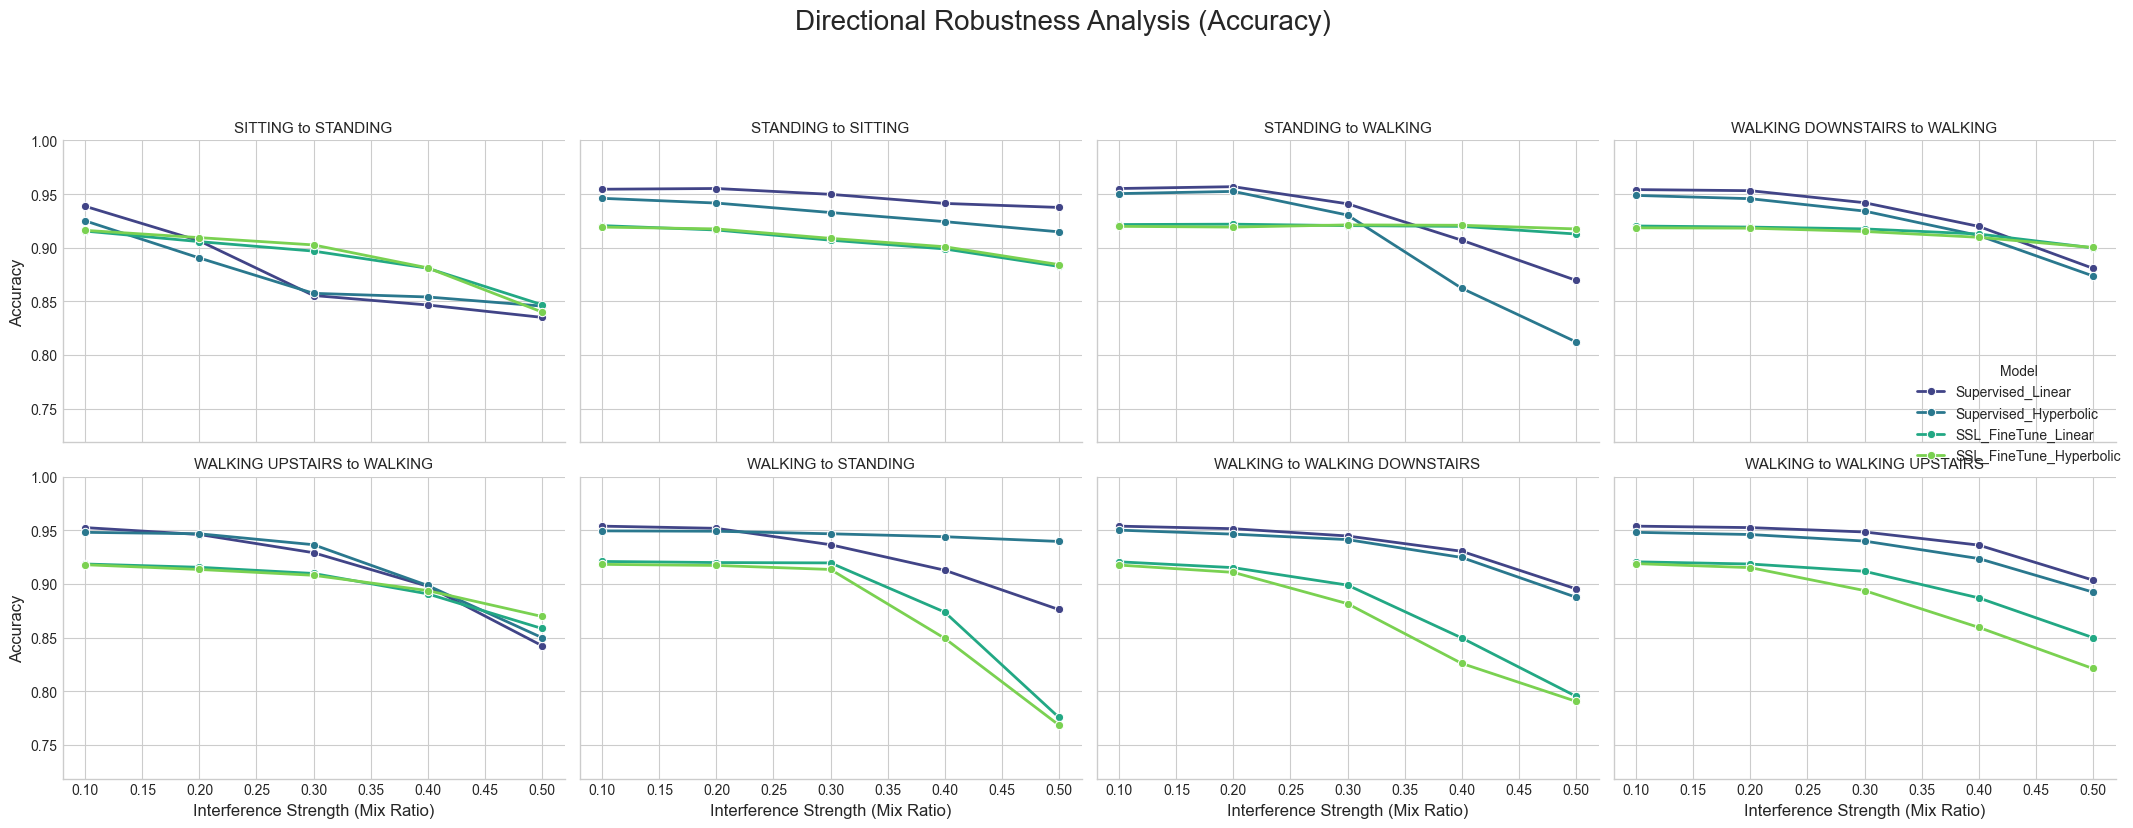

   - Saved visualization for F1-Score to C://Users/park9/HAR/SSL_HAR/MyFiles/02_Scenario_Experiment/RESLUTS\directional_robustness_F1-Score.png


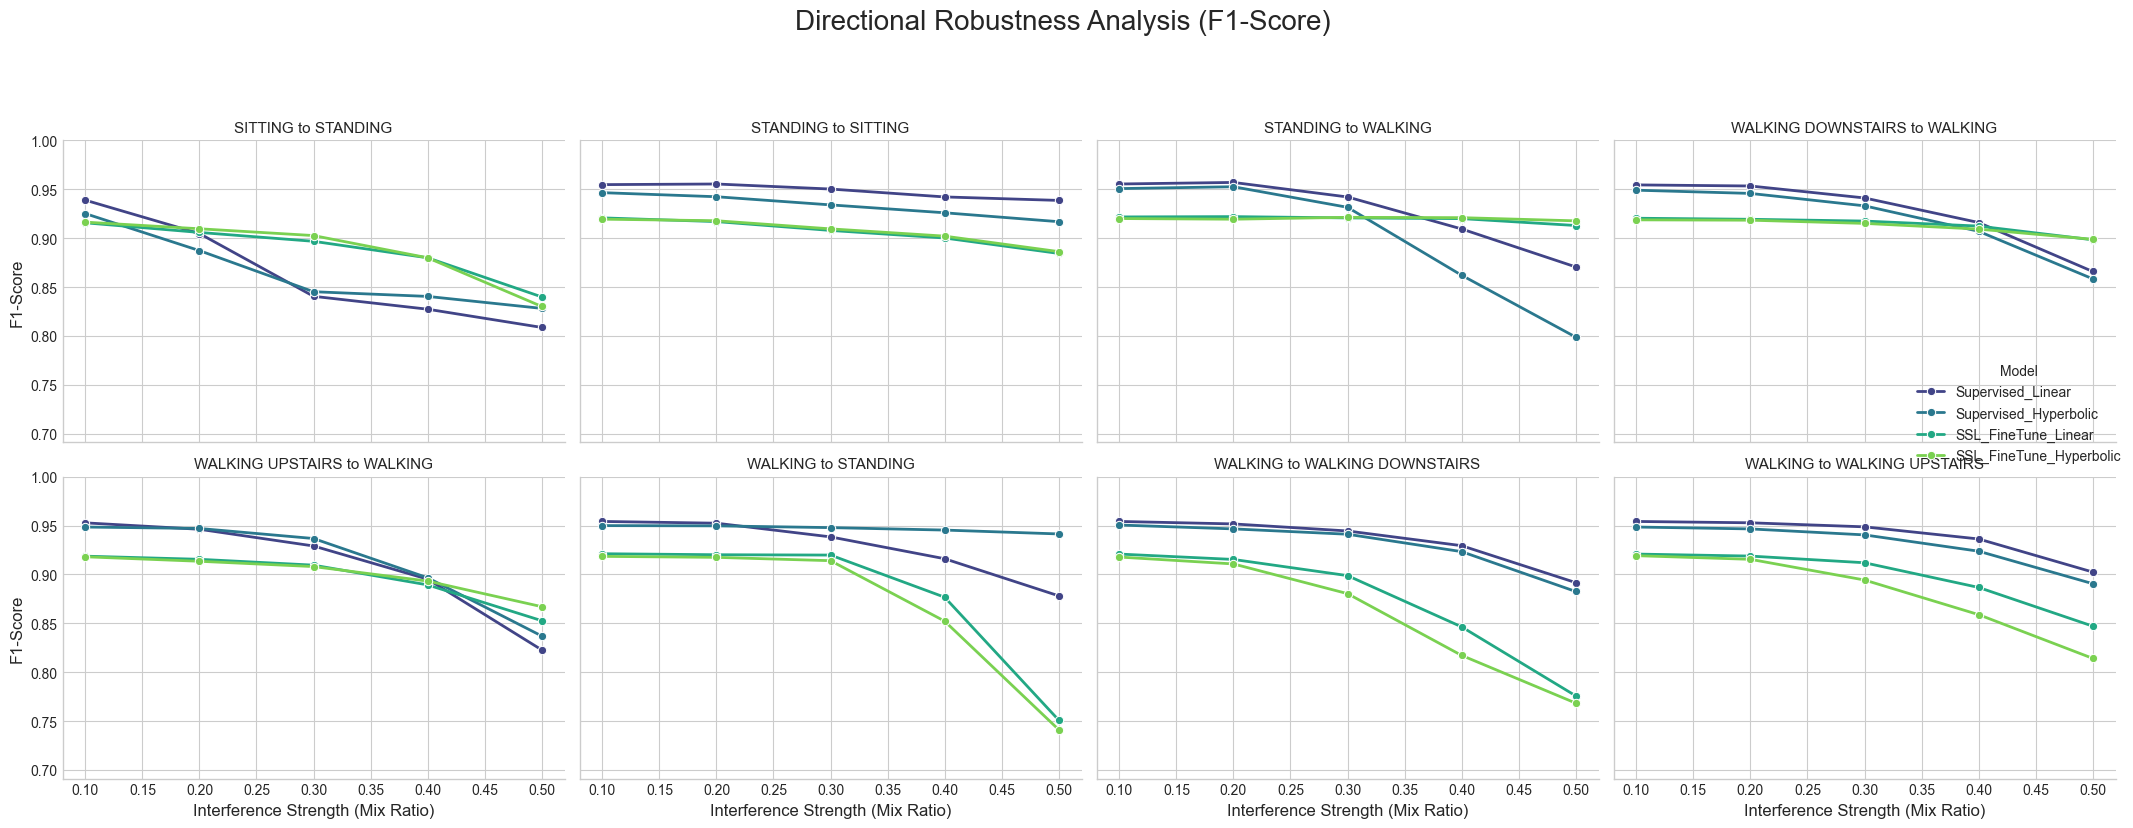

In [1]:
# ===================================================================
#          Full Experiment Code for Directional Analysis
#   Supervised vs. SSL Robustness on Directional Transitional HAR Data
# ===================================================================
import os
import random
import math
import copy
import json
from dataclasses import dataclass
from typing import Tuple, Dict, Optional
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ======================== 1. Random Seed ========================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ======================== 2. ❗Configuration (MODIFIED)❗ ========================
@dataclass
class Config:
    """실험 설정을 위한 데이터 클래스"""
    # 경로 설정
    data_dir: str = "C://Users/park9/HAR/SSL_HAR/data"  # 데이터셋 경로 
    save_dir: str = "C://Users/park9/HAR/SSL_HAR/MyFiles/02_Scenario_Experiment/RESLUTS" # 결과 저장 경로

    # SSL Pretrain 파라미터
    pretrain_epochs: int = 100
    pretrain_batch_size: int = 512
    pretrain_lr: float = 1e-3

    # Supervised / Fine-tune 파라미터
    finetune_epochs: int = 50
    finetune_batch_size: int = 128
    finetune_lr: float = 3e-4
    finetune_backbone_lr_ratio: float = 0.1

    # 공통 파라미터
    weight_decay: float = 1e-4
    grad_clip: float = 1.0
    label_smoothing: float = 0.05
    
    # 모델 파라미터
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    hyperbolic_c_init: float = 1.0

    # SSL 파라미터
    temperature: float = 0.07
    projection_dim: int = 128

    # ❗ Augmentation 파라미터 (수정됨)
    aug_max_segments: int = 8      # Permutation을 위한 최대 세그먼트 수
    aug_mask_ratio: float = 0.1    # Time-masking 비율
    aug_mag_warp_strength: float = 0.2  # Magnitude-warp 강도
    aug_time_warp_strength: float = 0.2 # Time-warp 강도
    aug_crop_ratio: float = 0.8    # Window-crop 비율

    # 시스템 파라미터
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 0

# ======================== 3. Dataset & Preprocessing ========================
INERTIAL_SIGNALS_FOLDER = "Inertial Signals"
RAW_CHANNELS = [
    ("total_acc_x_", "txt"), ("total_acc_y_", "txt"), ("total_acc_z_", "txt"),
    ("body_acc_x_", "txt"), ("body_acc_y_", "txt"), ("body_acc_z_", "txt"),
    ("body_gyro_x_", "txt"), ("body_gyro_y_", "txt"), ("body_gyro_z_", "txt"),
]
_LABEL_MAP = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LAYING"}
_CODE_TO_LABEL_NAME = {i-1: _LABEL_MAP[i] for i in _LABEL_MAP}
LABEL_NAME_TO_CODE = {v: k for k, v in _CODE_TO_LABEL_NAME.items()}

def load_split_raw(root: str, split: str):
    assert split in ("train", "test")
    inertial_path = os.path.join(root, split, INERTIAL_SIGNALS_FOLDER)
    if not os.path.isdir(inertial_path):
        raise FileNotFoundError(f"UCI-HAR 데이터셋 폴더를 찾을 수 없습니다: {inertial_path}")
    X_list = []
    for p, e in RAW_CHANNELS:
        fpath = os.path.join(inertial_path, f"{p}{split}.{e}")
        with open(fpath, "r", encoding="utf-8") as f: arr = np.loadtxt(f)
        X_list.append(arr[..., None])
    X = np.concatenate(X_list, axis=-1).transpose(0, 2, 1)
    y_path = os.path.join(root, split, f"y_{split}.txt")
    with open(y_path, "r", encoding="utf-8") as f: y = np.loadtxt(f).astype(int) - 1
    print(f"[OK] Loaded {split} data: X{X.shape}, y{y.shape}")
    return X, y

class UCIHARInertial(Dataset):
    def __init__(self, root: str, split: str, mean=None, std=None,
                 preloaded_data: Optional[Tuple[np.ndarray, np.ndarray]] = None):
        super().__init__()
        if preloaded_data is not None: X, y = preloaded_data
        else: X, y = load_split_raw(root, split)
        self.X_unnormalized = X.astype(np.float32)
        self.y = y.astype(np.int64)
        if mean is not None and std is not None: self.mean, self.std = mean, std
        else:
            self.mean = self.X_unnormalized.mean(axis=(0, 2), keepdims=True)
            self.std = self.X_unnormalized.std(axis=(0, 2), keepdims=True) + 1e-6
        self.X_normalized = (self.X_unnormalized - self.mean) / self.std
    def __len__(self): return self.X_unnormalized.shape[0]
    def __getitem__(self, idx):
        return (torch.from_numpy(self.X_normalized[idx]), torch.tensor(self.y[idx], dtype=torch.long))

# ======================== 4. ❗Augmentations (MODIFIED)❗ ========================

def _aug_time_warp(x: torch.Tensor, strength: float) -> torch.Tensor:
    """
    시간 축을 부드럽게 왜곡 (B, C, T)
    시간 축을 고무줄처럼 부드럽게 늘리거나 줄여, 행동의 속도 변화에 강건한 모델을 만듭니다.
    """
    B, C, T = x.shape
    device = x.device
    
    # 4개의 앵커 포인트 생성 (시작, 1/3, 2/3, 끝)
    anchor_points = torch.tensor([0, T/3, 2*T/3, T-1], device=device)
    
    # 앵커 포인트를 랜덤하게 왜곡
    warp_factors = (torch.rand(B, 1, 4, device=device) * 2 - 1) * strength * (T/3)
    warped_anchors = anchor_points.view(1, 1, 4) + warp_factors
    
    # 앵커 포인트를 T 길이로 선형 보간
    # F.interpolate는 (B, C, W) -> (B, C, T)
    t_warped = F.interpolate(warped_anchors, size=T, mode='linear', align_corners=True)
    
    # grid_sample을 위해 좌표를 [-1, 1]로 정규화
    grid_x = (t_warped / (T-1)) * 2 - 1
    
    # y좌표는 변경하지 않음
    grid_y = torch.linspace(-1, 1, C, device=device).view(1, C, 1).expand(B, C, T)
    
    # grid_sample은 [B, H, W, 2] 또는 [B, D, H, W, 2]가 필요함
    # 1D 신호를 [B, C, 1, T] (즉, H=1, W=T)로 간주
    x_reshaped = x.unsqueeze(2) # [B, C, 1, T]
    
    # grid_x: [B, 1, T] -> [B, 1, T, 1]
    # grid_y: [B, C, T] -> [B, 1, T, 1] (y는 0으로 고정해야 함)
    grid_y_fixed = torch.zeros(B, 1, T, 1, device=device)
    grid_x_reshaped = grid_x.permute(0, 2, 1).unsqueeze(1) # [B, 1, T, 1]
    
    grid = torch.cat([grid_x_reshaped, grid_y_fixed], dim=-1) # [B, 1, T, 2]
    
    warped = F.grid_sample(x_reshaped, grid, mode='bilinear', padding_mode='reflection', align_corners=True)
    return warped.squeeze(2) # [B, C, T]

def _aug_magnitude_warp(x: torch.Tensor, strength: float) -> torch.Tensor:
    """
    신호의 크기를 부드럽게 왜곡 (B, C, T)
    신호의 크기(진폭)를 부드럽게 변화시켜, 센서 측정값의 미세한 변동에 둔감해지도록 학습시킵니다.
    """
    B, C, T = x.shape
    device = x.device
    
    # 4개의 앵커 포인트 생성
    anchor_vals = torch.rand(B, C, 4, device=device) * 2 - 1
    warp_factors = anchor_vals * strength + 1.0
    
    # T 길이로 선형 보간하여 부드러운 왜곡 곡선 생성
    warp_curve = F.interpolate(warp_factors, size=T, mode='linear', align_corners=True)
    return x * warp_curve

def _aug_permutation(x: torch.Tensor, max_segments: int) -> torch.Tensor:
    """
    시간 세그먼트를 랜덤하게 섞음 (B, C, T)
    데이터를 여러 조각으로 나누고 그 순서를 섞어,
    모델이 시간 순서에만 의존하지 않고 데이터 조각들의 내용 자체에 집중하도록 만듭니다.
    """
    B, C, T = x.shape
    if T % max_segments != 0:
        # T가 max_segments로 나누어 떨어지지 않으면 패딩 후 자르기
        pad_len = max_segments - (T % max_segments)
        x_padded = F.pad(x, (0, pad_len), mode='reflect')
        T_padded = x_padded.shape[2]
    else:
        x_padded = x
        T_padded = T
        
    seg_len = T_padded // max_segments
    
    # [B, C, T] -> [B, C, max_segments, seg_len]
    x_split = x_padded.view(B, C, max_segments, seg_len)
    
    # 각 배치 항목마다 독립적인 순열 생성 [B, max_segments]
    perm = torch.rand(B, max_segments, device=x.device).argsort(dim=1)
    
    # [B, 1, max_segments, 1] -> [B, C, max_segments, seg_len]
    perm = perm.unsqueeze(1).unsqueeze(3).expand(B, C, max_segments, seg_len)
    
    # gather를 사용하여 순열 적용
    x_permuted = torch.gather(x_split, 2, perm)
    
    # [B, C, T_padded]
    x_permuted = x_permuted.view(B, C, T_padded)
    
    # 원본 길이로 자르기
    return x_permuted[:, :, :T]

def _aug_time_masking(x: torch.Tensor, mask_ratio: float) -> torch.Tensor:
    """
    시간 축의 일부를 마스킹 (0으로 설정) (B, C, T)
    데이터의 특정 구간을 0으로 만들어 가려버림으로써, 모델이 주변 정보를 바탕으로 가려진 부분을 추론하는 능력을 키웁니다.
    """
    B, C, T = x.shape
    mask_len = int(T * mask_ratio)
    if mask_len == 0: return x
    
    # 각 배치 항목마다 랜덤한 마스킹 시작 지점
    mask_start = torch.randint(0, T - mask_len + 1, (B, 1, 1), device=x.device)
    
    # 마스킹 영역 생성 [B, 1, T]
    indices = torch.arange(T, device=x.device).view(1, 1, T)
    mask = (indices >= mask_start) & (indices < (mask_start + mask_len))
    
    # 마스크 브로드캐스팅 [B, 1, T] -> [B, C, T]
    return x.masked_fill(mask, 0.0)

def _aug_window_crop(x: torch.Tensor, crop_ratio: float) -> torch.Tensor:
    """
    랜덤 윈도우를 크롭하고 원본 길이로 리사이즈 (B, C, T)
    데이터의 일부를 랜덤하게 잘라내 확대한 것처럼 보이게 하여,
    모델이 전체 데이터가 아닌 일부만 보고도 행동을 유추하는 능력을 기릅니다.
    """
    B, C, T = x.shape
    crop_len = int(T * crop_ratio)
    if crop_len == T: return x
    
    # 배치 전체에 동일한 크롭 적용 (간결성을 위해)
    start = torch.randint(0, T - crop_len + 1, (1,)).item()
    
    x_cropped = x[:, :, start : start + crop_len]
    
    # 선형 보간을 사용하여 원본 길이 T로 리사이즈
    return F.interpolate(x_cropped, size=T, mode='linear', align_corners=True)


def augment_time_series(x: torch.Tensor, cfg: Config) -> torch.Tensor:
    """
    요청된 5가지 증강 기법을 순차적으로 적용합니다.
    (순서는 강도에 따라 임의로 조정될 수 있습니다)
    """
    x_aug = x
    
    # 1. Time Warp
    x_aug = _aug_time_warp(x_aug, cfg.aug_time_warp_strength)
    
    # 2. Magnitude Warp
    x_aug = _aug_magnitude_warp(x_aug, cfg.aug_mag_warp_strength)
    
    # 3. Window Crop & Resize
    x_aug = _aug_window_crop(x_aug, cfg.aug_crop_ratio)
    
    # 4. Permutation (세그먼트 셔플)
    x_aug = _aug_permutation(x_aug, cfg.aug_max_segments)
    
    # 5. Time Masking
    x_aug = _aug_time_masking(x_aug, cfg.aug_mask_ratio)
    
    return x_aug

# ======================== 5. Model Architectures (No Changes) ========================
class ResBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__(); kernel_size=3
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels); self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, 1, kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels); self.downsample = downsample
    def forward(self, x):
        identity = x; out = self.relu(self.bn1(self.conv1(x))); out = self.bn2(self.conv2(out))
        if self.downsample is not None: identity = self.downsample(x)
        out += identity; return self.relu(out)

class ResNet1D(nn.Module):
    def __init__(self, in_channels=9, d_model=128, num_blocks=[2, 2, 2]):
        super().__init__(); self.in_channels = 64
        self.conv1 = nn.Conv1d(in_channels, 64, 7, 2, 3, bias=False); self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True); self.maxpool = nn.MaxPool1d(3, 2, 1)
        self.layer1 = self._make_layer(64, num_blocks[0], 1)
        self.layer2 = self._make_layer(128, num_blocks[1], 2)
        self.layer3 = self._make_layer(d_model, num_blocks[2], 2)
    def _make_layer(self, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(nn.Conv1d(self.in_channels, out_channels, 1, stride, bias=False), nn.BatchNorm1d(out_channels))
        layers = [ResBlock1D(self.in_channels, out_channels, stride, downsample)]; self.in_channels = out_channels
        for _ in range(1, num_blocks): layers.append(ResBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x))); x = self.maxpool(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__(); pe = torch.zeros(max_len, 1, d_model)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0, 0::2] = torch.sin(position * div_term); pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(0)]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model=128, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__(); self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout, 'gelu', True, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, n_layers); self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = x.permute(0, 2, 1); x = self.pos_encoder(x); x = self.dropout(x)
        x = self.transformer_encoder(x); return x.permute(0, 2, 1)

class ResNetTransformerBackbone(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        self.resnet = ResNet1D(in_channels=9, d_model=cfg.d_model)
        self.transformer = TransformerEncoder(cfg.d_model, cfg.n_heads, cfg.n_layers, cfg.dropout)
    def forward(self, x): return self.transformer(self.resnet(x))

class ProjectionHead(nn.Module):
    def __init__(self, d_model, projection_dim=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_model, d_model), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Linear(d_model, projection_dim))
    def forward(self, x): return self.net(x)

class SSLModel(nn.Module):
    def __init__(self, cfg: Config):
        super().__init__(); self.backbone = ResNetTransformerBackbone(cfg)
        self.projection_head = ProjectionHead(cfg.d_model, cfg.projection_dim)
        self.gap = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, x):
        pooled = self.gap(self.backbone(x)).squeeze(-1)
        # ❗ F.normalize 제거 (contrastive_loss에서 수행)
        return self.projection_head(pooled)

class ClassificationHead(nn.Module):
    def __init__(self, d_model: int, num_classes: int):
        super().__init__(); self.gap = nn.AdaptiveAvgPool1d(1); self.fc = nn.Linear(d_model, num_classes)
    def forward(self, fmap): return self.fc(self.gap(fmap).squeeze(-1))

class HyperbolicProjection(nn.Module):
    def __init__(self, c_init=1.0):
        super().__init__(); self.c = nn.Parameter(torch.tensor(c_init))
    def forward(self, x):
        c = torch.clamp(self.c, min=0.1, max=10.0)
        norm = torch.clamp(torch.norm(x, dim=-1, keepdim=True), min=1e-8)
        scale = torch.clamp(norm, max=(1.0/math.sqrt(c))-1e-4) / norm; return x * scale

class HyperbolicClassificationHead(nn.Module):
    def __init__(self, d_model: int, num_classes: int, c_init: float = 1.0):
        super().__init__(); self.gap = nn.AdaptiveAvgPool1d(1); self.pre_proj = nn.Linear(d_model, d_model)
        self.hyperbolic_proj = HyperbolicProjection(c_init=c_init); self.fc = nn.Linear(d_model, num_classes)
    def forward(self, fmap):
        h = self.pre_proj(self.gap(fmap).squeeze(-1)); return self.fc(self.hyperbolic_proj(h))

# ======================== 6. ❗Training & Evaluation Logic (MODIFIED)❗ ========================

def contrastive_loss(z1, z2, temp):
    """ ❗ 요청하신 안정화된 버전의 contrastive_loss로 교체 ❗ """
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)
    z = torch.cat([z1, z2], dim=0)                        # [2B, D]
    sim = z @ z.t()                                       # [2B, 2B]
    sim = sim - sim.max(dim=1, keepdim=True).values       # 행별 안정화
    B = z1.size(0)
    labels = torch.cat([torch.arange(B) + B, torch.arange(B)], 0).to(z.device)
    mask = torch.eye(2 * B, device=z.device, dtype=torch.bool)
    sim = sim.masked_fill(mask, -float('inf'))            # 자기자신 배제
    return F.cross_entropy(sim / temp, labels)

def pretrain_one_epoch(model, loader, opt, cfg):
    model.train(); total_loss, n = 0.0, 0
    for x, _ in loader:
        x1, x2 = augment_time_series(x.to(cfg.device), cfg), augment_time_series(x.to(cfg.device), cfg)
        opt.zero_grad(set_to_none=True)
        z1, z2 = model(x1), model(x2)
        loss = contrastive_loss(z1, z2, cfg.temperature) # ❗ 수정된 loss 함수 사용
        if torch.isnan(loss): continue
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip); opt.step()
        total_loss += loss.item() * x.size(0); n += x.size(0)
    return {"ssl_loss": total_loss / n if n > 0 else 0}

def train_downstream_epoch(backbone, head, loader, opt, cfg):
    backbone.train(); head.train(); total_loss, total_corr, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(cfg.device), y.to(cfg.device); opt.zero_grad(set_to_none=True)
        logits = head(backbone(x)); loss = F.cross_entropy(logits, y, label_smoothing=cfg.label_smoothing)
        loss.backward(); nn.utils.clip_grad_norm_(list(backbone.parameters()) + list(head.parameters()), cfg.grad_clip); opt.step()
        total_loss += loss.item() * y.size(0); total_corr += (logits.argmax(dim=-1) == y).sum().item(); n += y.size(0)
    return {"loss": total_loss / n if n > 0 else 0, "acc": total_corr / n if n > 0 else 0}

@torch.no_grad()
def evaluate_model(backbone, head, loader, cfg):
    backbone.eval(); head.eval(); y_true, y_pred = [], []
    for x, y in loader:
        logits = head(backbone(x.to(cfg.device)))
        y_pred.append(logits.argmax(dim=-1).cpu().numpy()); y_true.append(y.numpy())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

# ======================== 7. ❗Directional Test Set Creation (MODIFIED)❗ ========================
def create_directional_test_set(
    orig_dataset: UCIHARInertial,
    source_class: str,
    target_class: str,
    p: float,
    mix: float) -> Tuple[UCIHARInertial, dict]:
    """
    지정된 단일 방향(source_class -> target_class)으로만 전이 데이터를 생성합니다.
    """
    X_orig, y_orig = orig_dataset.X_unnormalized, orig_dataset.y
    X_mod, y_mod = X_orig.copy(), y_orig.copy()
    N, C, T = X_mod.shape

    code_source = LABEL_NAME_TO_CODE[source_class]
    code_target = LABEL_NAME_TO_CODE[target_class]
    
    idx_source = np.where(y_mod == code_source)[0]
    idx_target = np.where(y_mod == code_target)[0]
    mix_pts = int(T * mix)

    # Source -> Target 전이 생성 (Source 샘플의 뒷부분을 Target의 앞부분으로 교체)
    num_to_modify = int(len(idx_source) * p)
    targets_to_modify = np.random.choice(idx_source, num_to_modify, replace=False)
    source_pool_for_stitch = np.random.choice(idx_target, num_to_modify, replace=True)
    
    for target_idx, source_idx in zip(targets_to_modify, source_pool_for_stitch):
        X_mod[target_idx, :, -mix_pts:] = X_orig[source_idx, :, :mix_pts]
        
    mod_dataset = UCIHARInertial(
        root="", split="test", mean=orig_dataset.mean, std=orig_dataset.std,
        preloaded_data=(X_mod, y_mod)
    )
    info = {
        'source_class': source_class, 'target_class': target_class, 'p': p, 'mix': mix,
        'scenario_key': f"{source_class}_to_{target_class}"
    }
    return mod_dataset, info

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# ======================== 8. ❗Main Experiment Runner (MODIFIED)❗ ========================
def run_main_experiment(cfg: Config):
    os.makedirs(cfg.save_dir, exist_ok=True)

    print("📦 Loading UCI-HAR Dataset...")
    train_set = UCIHARInertial(cfg.data_dir, "train")
    test_set_orig = UCIHARInertial(cfg.data_dir, "test", mean=train_set.mean, std=train_set.std)
    finetune_loader = DataLoader(train_set, cfg.finetune_batch_size, shuffle=True, num_workers=cfg.num_workers)
    test_loader_orig = DataLoader(test_set_orig, cfg.finetune_batch_size, num_workers=cfg.num_workers)

    # ❗ 단방향 시나리오 정의 (총 8개)
    directional_scenarios = [
        ("STANDING", "WALKING"), ("WALKING", "STANDING"),
        ("STANDING", "SITTING"), ("SITTING", "STANDING"),
        ("WALKING", "WALKING_DOWNSTAIRS"), ("WALKING_DOWNSTAIRS", "WALKING"),
        ("WALKING", "WALKING_UPSTAIRS"), ("WALKING_UPSTAIRS", "WALKING"),
    ]
    mix_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

    print("\\n" + "="*25 + "\\n🔬 Creating Directional Transitional Test Sets (Total: 40)..." + "\\n" + "="*25)
    transition_test_data = []
    for source_cls, target_cls in directional_scenarios:
        for mix_ratio in mix_ratios:
            # p=1.0: 해당 클래스의 모든 샘플을 변형 대상으로 고려
            test_set_mod, info = create_directional_test_set(test_set_orig, source_cls, target_cls, p=1.0, mix=mix_ratio)
            transition_test_data.append((test_set_mod, info))
            print(f"   - Created: {info['scenario_key']} (mix={info['mix']:.1f})")

    experiment_configs = [
        {"name": "Supervised_Linear", "method": "supervised", "use_hyperbolic": False},
        {"name": "Supervised_Hyperbolic", "method": "supervised", "use_hyperbolic": True},
        {"name": "SSL_FineTune_Linear", "method": "ssl", "use_hyperbolic": False},
        {"name": "SSL_FineTune_Hyperbolic", "method": "ssl", "use_hyperbolic": True},
    ]
    
    all_results = []

    for exp_cfg in experiment_configs:
        print(f"\\n{'='*25}\\n   🚀 Starting Experiment: {exp_cfg['name']}\\n{'='*25}")
        random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

        # --- Model Training ---
        if exp_cfg['method'] == 'supervised':
            backbone = ResNetTransformerBackbone(cfg).to(cfg.device)
            head = (HyperbolicClassificationHead(cfg.d_model, 6, cfg.hyperbolic_c_init) if exp_cfg['use_hyperbolic']
                    else ClassificationHead(cfg.d_model, 6)).to(cfg.device)
            opt = torch.optim.AdamW(list(backbone.parameters()) + list(head.parameters()), lr=cfg.finetune_lr, weight_decay=cfg.weight_decay)
            train_fn = train_downstream_epoch
        else: # SSL
            print("  -- Stage 1: Self-Supervised Pretraining --")
            ssl_model = SSLModel(cfg).to(cfg.device)
            pretrain_loader = DataLoader(train_set, cfg.pretrain_batch_size, shuffle=True, num_workers=cfg.num_workers)
            ssl_opt = torch.optim.AdamW(ssl_model.parameters(), lr=cfg.pretrain_lr, weight_decay=cfg.weight_decay)
            for epoch in range(1, cfg.pretrain_epochs + 1):
                stats = pretrain_one_epoch(ssl_model, pretrain_loader, ssl_opt, cfg)
                if epoch % 20 == 0: print(f"  [Pretrain Epoch {epoch:03d}] SSL Loss: {stats['ssl_loss']:.4f}")
            
            print("  -- Stage 2: Fine-tuning --")
            backbone = ssl_model.backbone
            head = (HyperbolicClassificationHead(cfg.d_model, 6, cfg.hyperbolic_c_init) if exp_cfg['use_hyperbolic']
                    else ClassificationHead(cfg.d_model, 6)).to(cfg.device)
            opt = torch.optim.AdamW([
                {'params': backbone.parameters(), 'lr': cfg.finetune_lr * cfg.finetune_backbone_lr_ratio},
                {'params': head.parameters(), 'lr': cfg.finetune_lr}], weight_decay=cfg.weight_decay)
            train_fn = train_downstream_epoch

        best_acc, best_wts = 0.0, None
        for epoch in range(1, cfg.finetune_epochs + 1):
            stats = train_fn(backbone, head, finetune_loader, opt, cfg)
            te_acc, _ = evaluate_model(backbone, head, test_loader_orig, cfg)
            if te_acc > best_acc:
                best_acc = te_acc
                best_wts = {'backbone': copy.deepcopy(backbone.state_dict()), 'head': copy.deepcopy(head.state_dict())}
            if epoch % 10 == 0: print(f"  [Downstream Epoch {epoch:02d}] Train Loss: {stats['loss']:.4f}, Acc: {stats['acc']:.4f} | Test Acc: {te_acc:.4f}")
        
        print(f"  ✨ Best Test Accuracy: {best_acc:.4f}")
        backbone.load_state_dict(best_wts['backbone']); head.load_state_dict(best_wts['head'])

        # --- Evaluation ---
        acc_orig, f1_orig = evaluate_model(backbone, head, test_loader_orig, cfg)
        print(f"\\n  ✅ Final Original Test Performance: Acc={acc_orig:.4f}, F1={f1_orig:.4f}")
        
        transition_results_detailed = {}
        print("  🔍 Evaluating on directional transitional test sets...")
        for test_set_mod, info in transition_test_data:
            test_loader_mod = DataLoader(test_set_mod, cfg.finetune_batch_size, num_workers=cfg.num_workers)
            acc_trans, f1_trans = evaluate_model(backbone, head, test_loader_mod, cfg)
            scenario_key = info['scenario_key']
            if scenario_key not in transition_results_detailed: transition_results_detailed[scenario_key] = []
            transition_results_detailed[scenario_key].append({"mix_ratio": info['mix'], "acc": acc_trans, "f1": f1_trans})
        
        all_results.append({
            "config": exp_cfg["name"], "orig_acc": acc_orig, "orig_f1": f1_orig,
            "transition_results": transition_results_detailed})

    save_path = os.path.join(cfg.save_dir, "directional_experiment_results.json")
    with open(save_path, "w") as f: json.dump(all_results, f, indent=2, cls=NumpyEncoder)
    print(f"\\n\\n🎉 All experiment results saved to: {save_path}")

# ======================== 9. ❗Analysis & Visualization (MODIFIED)❗ ========================
def analyze_and_visualize_results(save_dir: str):
    results_path = os.path.join(save_dir, "directional_experiment_results.json")
    try:
        with open(results_path, 'r') as f: results_data = json.load(f)
    except FileNotFoundError:
        print(f"🚨 Error: Results file not found at {results_path}"); return

    print("\\n" + "="*25 + "\\n    📊 Directional Experiment Analysis & Visualization" + "\\n" + "="*25)
    records = []
    for result in results_data:
        for scenario, values in result['transition_results'].items():
            for value in values:
                records.append({'Model': result['config'], 'Scenario': scenario.replace('_', ' '),
                                'Mix Ratio': value['mix_ratio'], 'Accuracy': value['acc'], 'F1-Score': value['f1']})
    df = pd.DataFrame(records)
    if df.empty: print("No data to visualize."); return

    for metric in ['Accuracy', 'F1-Score']:
        plt.style.use('seaborn-v0_8-whitegrid')
        # ❗ col_wrap=4로 변경하여 4열로 8개 그래프 표시 (원본 유지)
        g = sns.FacetGrid(df, col="Scenario", col_wrap=4, hue="Model", height=4, aspect=1.2,
                          col_order=sorted(df['Scenario'].unique()),
                          palette='viridis', margin_titles=True)
        g.map(sns.lineplot, "Mix Ratio", metric, marker='o', linewidth=2).add_legend(title="Model")
        g.fig.suptitle(f'Directional Robustness Analysis ({metric})', fontsize=20, y=1.03)
        g.set_axis_labels("Interference Strength (Mix Ratio)", metric, fontsize=12)
        g.set_titles(col_template="{col_name}", size=11)
        g.set(ylim=(min(df[metric]) - 0.05, 1.0))
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        fig_path = os.path.join(save_dir, f"directional_robustness_{metric}.png")
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"   - Saved visualization for {metric} to {fig_path}")
        plt.show()

# ======================== 10. Main Entry Point ========================
if __name__ == "__main__":
    config = Config()
    print("="*25)
    print("   🔬 Directional Main Experiment: Model Robustness on Transitional Data")
    print("="*80)
    print(f"   - Total directional scenarios: 8")
    print(f"   - Mix ratios per scenario: 5")
    print(f"   - Total transitional evaluations per model: {8 * 5}")
    print(f"   - Results will be saved in: {config.save_dir}")
    print("="*25 + "\\n")
    
    # ❗ 1단계: 실험 실행 (시간이 오래 걸립니다)
    run_main_experiment(config)

    # ❗ 2단계: 실험 완료 후 결과 분석 및 시각화
    analyze_and_visualize_results(config.save_dir)